# Objects To Key-Value for Graphs Manipulation

An etude of API for object-graph manipulation by storing the graph as a flat key-value representation.  


Why? Numba IR is...

- **Under-engineered** for the increasing use of transformation passes
- **Error-prone**; i.e. misuse, out-of-sync states, cannot copy cleanly

Goals:

- Simple object manipulation API
- Allow **cycles** directly
- **Avoid dangling** references



In [1]:
from kvbacker import ResourceManager, Managed, ManagedList

`ResourceManager` will own all the `Managed` object.

In [2]:
rm = ResourceManager()

In [3]:
rm

Create a `Managed` type. Note: use `init` instead of `__init__`.

In [4]:
class MyNode(Managed):
    def init(self, data, next=None):
        self.data = data
        self.next = next

We'll need a separate allocator.

In [5]:
n1 = rm.new(MyNode, data=123)
n1

MyNode@1(data=123, next=None)

Dump the state in the `ResourceManager`

In [6]:
print(rm.dump())

{object_entry(objid=0): object_meta(cls=<class 'kvbacker.Infos'>, attrs=frozenset()),
 object_entry(objid=1): object_meta(cls=<class '__main__.MyNode'>, attrs=frozenset({'data', 'next'})),
 attr_entry(objid=1, name='data'): 123,
 attr_entry(objid=1, name='next'): None,
 '__heap__': {'new_slot': 2}}


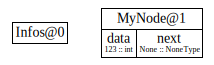

In [7]:
rm.visualize()

Create another instance

In [8]:
n2 = rm.new(MyNode, data=321, next=n1)

In [9]:
print(rm.dump())

{object_entry(objid=0): object_meta(cls=<class 'kvbacker.Infos'>, attrs=frozenset()),
 object_entry(objid=1): object_meta(cls=<class '__main__.MyNode'>, attrs=frozenset({'data', 'next'})),
 attr_entry(objid=1, name='data'): 123,
 attr_entry(objid=1, name='next'): None,
 object_entry(objid=2): object_meta(cls=<class '__main__.MyNode'>, attrs=frozenset({'data', 'next'})),
 attr_entry(objid=2, name='data'): 321,
 attr_entry(objid=2, name='next'): flatten_entry(handle=object_entry(objid=1)),
 '__heap__': {'new_slot': 3}}


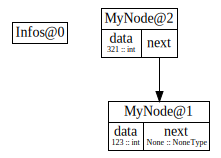

In [10]:
rm.visualize()

List all the **referers** to `n1`

In [11]:
list(rm.iter_referers(n1))

[_iter_referers_result(referer=MyNode@2(data=321, next=MyNode@1(data=123, next=None)), attrname='next')]

List all the **referents** to `n2`

In [12]:
list(rm.iter_referents(n2))

[_iter_referents_result(attrname='data', referent=321),
 _iter_referents_result(attrname='next', referent=MyNode@1(data=123, next=None))]

Build another one to show double reference to the same node

In [13]:
n3 = rm.new(MyNode, data=n2, next=n1)

In [14]:
n3

MyNode@3(data=MyNode@2(data=321, next=MyNode@1(data=123, next=None)), next=@1)

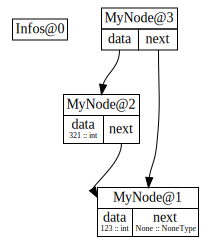

In [15]:
rm.visualize()

Replace all `n1` with `n2` in the graph.

In [16]:
rm.replace_all(n1, n2)

2

In [30]:
n3

MyNode@3(data=MyNode@2(data=321, next=@3), next=@2)

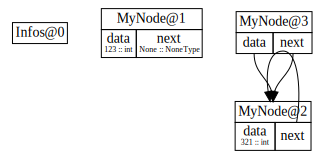

In [17]:
rm.visualize()

Make **cyclic reference**

In [18]:
n2.next = n3

In [19]:
n2

MyNode@2(data=321, next=MyNode@3(data=@2, next=@2))

In [20]:
print(rm.dump())

{object_entry(objid=0): object_meta(cls=<class 'kvbacker.Infos'>, attrs=frozenset()),
 object_entry(objid=1): object_meta(cls=<class '__main__.MyNode'>, attrs=frozenset({'data', 'next'})),
 attr_entry(objid=1, name='data'): 123,
 attr_entry(objid=1, name='next'): None,
 object_entry(objid=2): object_meta(cls=<class '__main__.MyNode'>, attrs=frozenset({'data', 'next'})),
 attr_entry(objid=2, name='data'): 321,
 attr_entry(objid=2, name='next'): flatten_entry(handle=object_entry(objid=3)),
 object_entry(objid=3): object_meta(cls=<class '__main__.MyNode'>, attrs=frozenset({'data', 'next'})),
 attr_entry(objid=3, name='data'): flatten_entry(handle=object_entry(objid=2)),
 attr_entry(objid=3, name='next'): flatten_entry(handle=object_entry(objid=2)),
 '__heap__': {'new_slot': 4}}


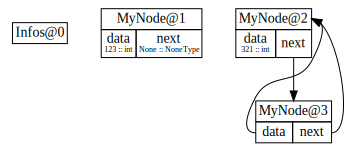

In [21]:
rm.visualize()

### Serializable/Cloneable

In [22]:
rm.infos.n2 = n2
rm.infos.n1 = n1

In [23]:
import pickle

mr = pickle.loads(pickle.dumps(rm))

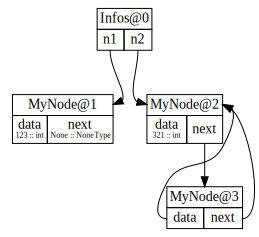

In [24]:
rm.visualize()

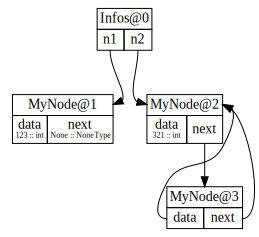

In [25]:
mr.visualize()

### Clones are dettached

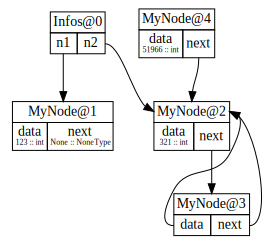

In [26]:
rm.new(MyNode, data=0xcafe, next=n2)
rm.visualize()

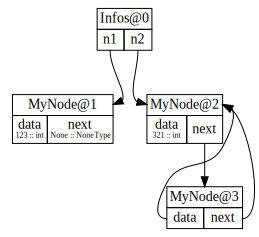

In [27]:
mr.visualize()

### Strict Membership

In [28]:
mr.infos.n2 = rm.infos.n2

ValueError: Cannot migrate Managed objects between different ResourceManager instances

### Restricted types

In [29]:
rm.infos.new = []

ValueError: cannot use value of type <class 'list'>

## Other Properties

### Extensible:
* Change dictionary implementation for additional features:
    * transactional? 
    * disk-storage? `partd`?
